In [1]:
import torch
from torch import autograd
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')

### 1. Загрузите и подготовьте данные

In [2]:
data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
data.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
data = data.dropna()

In [6]:
data['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: count, dtype: int64

In [7]:
data = data.drop(data[data['ocean_proximity'] == 'ISLAND'].index)

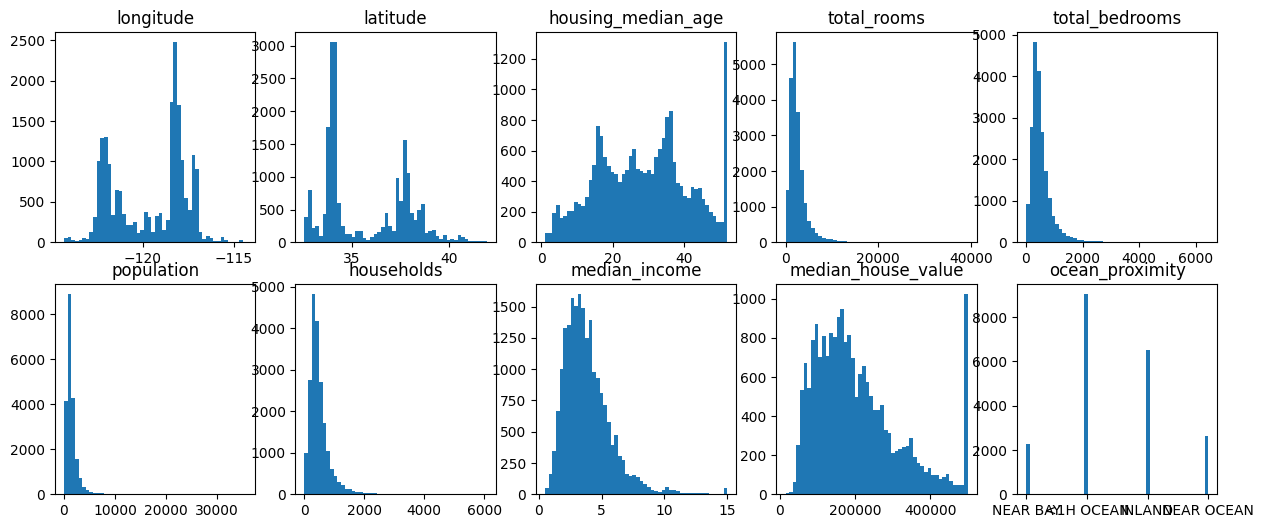

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15, 6))
for i, feature in enumerate(list(data.columns), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title(feature)
    plt.hist(data[feature], bins=50)

### 2. Разделите данные на test и train

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [32]:
le = LabelEncoder()
data['ocean_proximity']= le.fit_transform(data['ocean_proximity']) 

In [33]:
X = data.loc[:, data.columns != 'median_house_value']
y = data['median_house_value']

X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

X = X.astype('float32')
y = y.astype('float32')

In [34]:
features = torch.Tensor(X.values)
labels = torch.Tensor(y.values)

In [35]:
X_train,  X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=13)

### 3. Создать модель (объект) класса. Для создания объекта можно использовать класс Sequential

In [36]:
batch_size = 10
dataset = TensorDataset(X_train, y_train)
data_iter = DataLoader(dataset, batch_size, shuffle=True)

for X, y in data_iter:
    print(X, y)
    break

tensor([[ 0.7890, -0.8912, -0.9237,  1.1907,  1.2033,  0.8955,  1.2699,  0.2651,
         -0.8985],
        [-1.3221,  1.0515, -0.6855, -1.1631, -1.2456, -1.2302, -1.2672, -0.7513,
          1.0418],
        [-1.8711,  1.7724, -0.5266, -0.2525, -0.2513, -0.2578, -0.2550, -0.7796,
         -0.8985],
        [ 0.2800, -0.1843, -1.7975, -1.1699, -1.2384, -1.1993, -1.2515, -0.3930,
          0.0716],
        [-0.8529,  1.0702,  0.5854, -0.9782, -1.0035, -0.8596, -0.9821, -0.8955,
          0.0716],
        [ 0.6393, -0.7273,  0.7443, -1.0327, -0.9679, -0.8649, -0.9403, -1.0229,
         -0.8985],
        [ 0.8889, -0.8724, -0.4472,  0.4389, -0.2062, -0.1175, -0.1085,  2.4581,
         -0.8985],
        [-1.8910,  1.6928, -0.9237, -0.7091, -0.6737, -0.7969, -0.7781, -0.6760,
         -0.8985],
        [ 0.6892, -0.8678,  0.0294, -0.6712, -0.4008, -0.0239, -0.3308, -0.8514,
          2.0119],
        [-0.8679,  1.2294, -0.5266, -0.3975, -0.3367, -0.3707, -0.2079, -1.0460,
          0.0716]])

In [37]:
X_train.shape

torch.Size([16342, 9])

In [46]:
model = torch.nn.Sequential(
    torch.nn.Linear(9, 1),
    torch.nn.Sigmoid()
)

loss = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### 4. Обучите модель на train данных

In [56]:
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        optimizer.zero_grad()
        l = loss(model(X).reshape(-1), y)
        l.backward()
        optimizer.step()
    l = loss(model(X_train).reshape(-1), y_train)
    if epoch % 10 == 0:
        print('epoch %d, loss: %f' % (epoch, l.item()))  

epoch 10, loss: 0.018356
epoch 20, loss: 0.018351
epoch 30, loss: 0.018352
epoch 40, loss: 0.018352
epoch 50, loss: 0.018351
epoch 60, loss: 0.018365
epoch 70, loss: 0.018364
epoch 80, loss: 0.018353
epoch 90, loss: 0.018357
epoch 100, loss: 0.018358


### 5. Проверьте качество модели на тестовых данных

#### 5.1 Тестовый лосс (не уверен что корректно)

In [48]:
test = loss(model(X_test).reshape(-1), y_test)
print('test loss: %f' % (test.item()))

test loss: 0.018512


#### 5.2 ручная функция MSE, тоже не совсем ясно, что происходит

In [49]:
import numpy as np

In [70]:
# with torch.no_grad():
predicted = model(X_test).detach().numpy()

In [51]:
def calculate_mse(predicted, actual):

    assert len(predicted) == len(actual), "Длины массивов должны быть одинаковыми."

    # Вычисление суммы квадратов разностей
    squared_errors = np.square(predicted - actual)
    sum_squared_errors = np.sum(squared_errors)

    # Вычисление MSE
    mse = sum_squared_errors / len(predicted)

    return mse

In [71]:
mse = calculate_mse(predicted, y_test.numpy())
print("TEST MSE:", mse)

TEST MSE: 381.31721120900636


#### 5.3 Веса и байес, берем по позиции тензоров тестовых X и y и сверяем через функцию сигмойды и сравниваем с предсказаниями

In [63]:
W, B = model[0].weight.data.numpy(), model[0].bias.data.numpy()
X_test[54,:], y_test[54]

(tensor([ 0.8340, -0.6992,  0.5060, -0.1729, -0.0781,  0.1199,  0.0249, -0.2986,
         -0.8985]),
 tensor(0.2897))

In [65]:
test1 = X_test[54,:].numpy()

In [66]:
def sigmoid(x):
    return 1 / ( 1 + np.exp(-x))

In [68]:
predict = np.dot(W, test1) + B
sigmoid(predict)

array([0.31100732], dtype=float32)

In [69]:
predict = model(torch.Tensor(test1))
predict

tensor([0.3110], grad_fn=<SigmoidBackward0>)